# Download Dataset

In [1]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

extract_tar_gz('xray_dataset.tar.gz', '.')

--2023-06-21 23:28:09--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.216.38.145, 3.5.28.100, 54.231.233.153, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.216.38.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  13.1MB/s    in 91s     

2023-06-21 23:29:41 (12.8 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



# Detect Pneumonia Using X-Ray Images with CNNs and Transfer Learning

In this project we will build two deep learning models and train them on a dataset containing images of chest X-rays. The aim of this project is to train classifiers on the dataset that can accurately predict whether an X-ray indicates any signs of pneumonia or not.

The models could then be used for developing tools that could aid hospitals in accurately identifying whether a patient has a particular disease or not.

## 1. Introduction

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input, applications, initializers
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size))

normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


## 2. Data Exploration

In [4]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [5]:
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
    images = images.numpy()
    labels = labels.numpy()

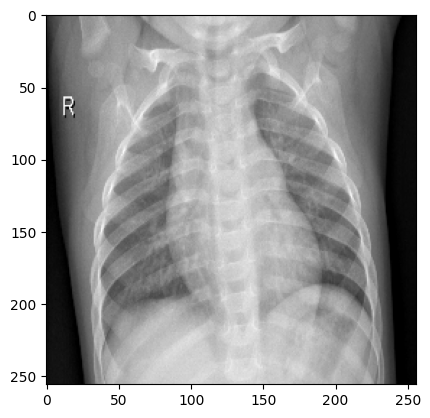

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


In [6]:
idx = 0
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

In [7]:
test_set_elem = test_set.take(1)
for images, labels in test_set_elem:
    images = images.numpy()

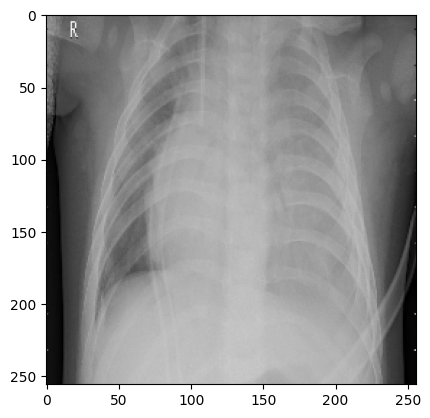

Test Set Image Label: [0. 1.]


In [8]:
idx = 16
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Test Set Image Label: {labels[idx]}")

The X-rays are not centered. The images are all rotated at different angles. Additionally, even though the images look to be in greyscale, they have `3` channels.

The images don't seem to have a lot of information, but, because of the overlap of ribs and lungs, it could be difficult to extract features specific to the infection. A more complex model could perhaps manage to extract relevant features.

Given the differences between how the X-rays were taken, the images could be rotated, at the very least, as part of data augmentation.

## 3. First Model: Simple CNN I

In [9]:
first_model = models.Sequential()

first_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(16, activation='relu'))
first_model.add(layers.Dense(2))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

first_model.summary()

first_model.fit(train_set_normalized, epochs=5, validation_data=validation_set_normalized)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 16)                1016080   
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,016,562
Trainable params: 1,016,562
Non-trainable params: 0
______________________________________________

Both the validation and training accuracies are quite high even though the model was trained for only `5` epochs. It is possible the model is overfitting. Adding regularization, data augmentation, and more fully-connected layers could help prevent some overfitting while still ensuring good performance.

## 4. First Model: Simple CNN II

In [10]:
first_model = models.Sequential()

first_model.add(layers.RandomZoom(height_factor=0.1))
first_model.add(layers.RandomRotation(factor=0.2))

first_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))

first_model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(256, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(64, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(32, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(2))

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
first_model.build((None, img_size, img_size, 3))

first_model.summary()
first_model.fit(train_set_normalized, epochs=15, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 256)     

The architecture was modified a few times to try and reduce overfitting while still yielding reasonable performance. The experimentation included:

- Trying different combinations of data augmentation layers.
- Increasing the number of filters, trying different sizes, different strides, and number of convolutional layers.
- Adding more fully-connected layers with a different number of units.
- Removing batch normalization layers after the fully-connected layers and replacing them with dropout layers. Before this change, the model's performance was a bit erratic.
- Reducing the learning rate helped the model to converge.
- Adding an early stopping callback that would stop the training if the validation loss didn't decrease for three consecutive epochs. Using the `restore_best_weights` argument ensured that the model would use weights from the epoch with the lowest validation loss only.

## 5. Second Model: Transfer Learning

In [11]:
base_model = applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

base_model.trainable = False

input_layer = Input(shape=(img_size, img_size, 3))

preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = base_model(preprocessed_input_layer, training=False)

global_pooling = layers.GlobalAveragePooling2D()(features_layer)

fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

output = layers.Dense(2)(fc3)

second_model = Model(inputs=input_layer, outputs=output)

second_model.summary()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                      

In [12]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable=False

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping_callback])

Epoch 1/5
33/33 [==============================] - 48s 1s/step - loss: 0.1525 - accuracy: 0.9381 - val_loss: 0.1518 - val_accuracy: 0.9426
Epoch 2/5
33/33 [==============================] - 40s 1s/step - loss: 0.1080 - accuracy: 0.9613 - val_loss: 0.1097 - val_accuracy: 0.9570
Epoch 3/5
33/33 [==============================] - 40s 1s/step - loss: 0.0915 - accuracy: 0.9630 - val_loss: 0.0917 - val_accuracy: 0.9665
Epoch 4/5
33/33 [==============================] - 39s 1s/step - loss: 0.0880 - accuracy: 0.9651 - val_loss: 0.1188 - val_accuracy: 0.9551
Epoch 5/5
33/33 [==============================] - 40s 1s/step - loss: 0.0789 - accuracy: 0.9701 - val_loss: 0.0791 - val_accuracy: 0.9656


The ResNet v2 architecture was selected since it was stated to be a better alternative to the original ResNet per the research paper.

We included the same data augmentation layers as the first model. Instead of flattening the layers, we used a global pooling average layer followed by three fully-connected layers and an output layer. We also included an early stopping callback like with the previous model.

We experimented with the number of layers to unfreeze for fine-tuning. Unfreezing layers beyond the last `10` either had diminishing returns or it worsened the model's performance.

The model doesn't seem to be overfitting given the added regularization and data augmentation, and the progression of the accuracy and loss values during training.

## 6. Evaluating on the Test Set

In [13]:
first_model_test_loss, first_model_test_acc = first_model.evaluate(test_set_normalized)

print(f"Test set accuracy of first model: {first_model_test_acc}")

second_model_test_loss, second_model_test_acc = second_model.evaluate(test_set)

print(f"Test set accuracy of second model: {second_model_test_acc}")


5/5 [==============================] - 4s 280ms/step - loss: 0.3667 - accuracy: 0.8365
Test set accuracy of first model: 0.8365384340286255
5/5 [==============================] - 9s 2s/step - loss: 0.4675 - accuracy: 0.8381
Test set accuracy of second model: 0.8381410241127014


The second model, using transfer learning, outperforms the first model but not by a *significant* margin. The test set accuracies of both the models are not much lower than that their respective validation accuracies. That can be considered a good sign that the model probably isn't overfitting.

The accuracy of either of the models is not high enough to be suitable for a medical diagnosis, in our opinion. However, the second model with some more training and experimentation is likely to yield better performance given the lack of additional data.